# MNIST en Deep Learning

Dans ce TP, nous allons construire des algorithmes de Deep Learning pour tenter de reconnaître des chiffres manuscrits.

## Chargement des données et transformation

Nous allons travailler sur la base de données MNIST qui contient 60000 images en niveaux de grille de résolution 28x28, représentant les 10 chiffres de 0 à 9, ainsi qu'un jeu de test de 10000 images. Tout d'abord, chargeons ce jeu de données.

In [1]:
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchinfo import summary
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
import scipy
import scipy.ndimage
import time
import numpy as np
from torchmetrics import Accuracy

Chargement des données MNIST

In [2]:
train_dataset = datasets.MNIST('../data', train=True, transform=ToTensor())
test_dataset = datasets.MNIST('../data', train=False, transform=ToTensor())
if torch.cuda.is_available():
    device = torch.device('cuda')
    torch.cuda.set_device(0)
else:
    device = torch.device('cpu')

Créer un dataloader et visualiser des images

BATCH INFO : input shape:  torch.Size([16, 1, 28, 28])  , labels shape:  torch.Size([16]) 



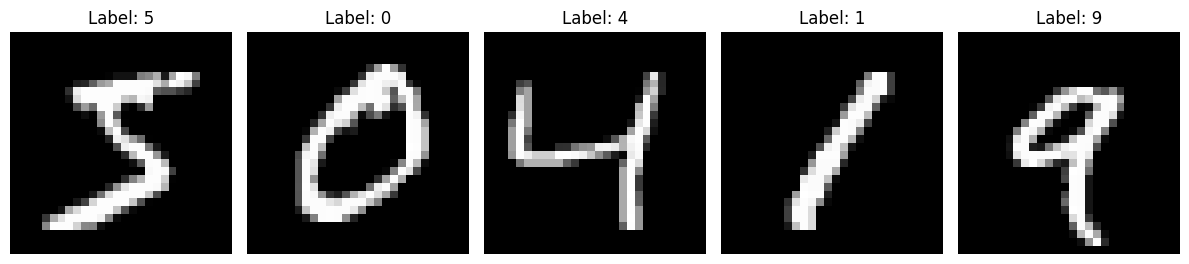

In [3]:
train_dataloader = DataLoader(train_dataset, batch_size=16)


# Parcourez un batch dans le DataLoader
for images, labels in train_dataloader:
    print("BATCH INFO : input shape: ", images.shape, " , labels shape: ", labels.shape, '\n')
    sample_images = images[:5]  # Les 5 premières images
    sample_labels = labels[:5]  # Les 5 premières étiquettes
    break  # On prend seulement le premier batch

# Affichez les images et leurs étiquettes
fig, axes = plt.subplots(1, 5, figsize=(12, 3))

for i, ax in enumerate(axes):
    ax.imshow(
        sample_images[i].squeeze(), cmap="gray"
    )  # .squeeze() pour retirer la dimension du canal
    ax.set_title(f"Label: {sample_labels[i].item()}")
    ax.axis("off")

plt.tight_layout()
plt.show()

## Construire un premier réseau de neurones

Construisons notre premier réseau de neurones.

Pour cela, nous allons créer un modèle Pytorch en utilisant la classe `nn.Module` vu précedemment.

Puis utiliser les méthodes suivantes de Pytroch pour ajouter des couches à ce modèle :

* `nn.FLatten` : on manipule des vecteurs et non des image, on passe de (28,28) -> (784,)
* `nn.Linear` : on ajoute une couche dense (ou linéaire)
* `nn.Dropout` : applique un dropout à la couche, pour éviter le surapprentissage
* `nn.ReLU` : fonction d'activation relu au coeur du réseau
* `nn.Softmax` : en sortie de réseau

In [4]:
nb_classes = 10
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(784, 1024)  #
        self.fc2 = nn.Linear(1024, 512)   
        self.fc3 = nn.Linear(512, 512)   
        self.fc4 = nn.Linear(512, nb_classes) 
        #self.dropout = nn.Dropout(0.5) # Couche de dropout
        self.relu = nn.ReLU()    # Fonction d'activation sigmoïde
        self.softmax = nn.Softmax(dim=1) # Fonction d'activation softmax

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x)) # Activation sigmoid pour la première couche
        x = self.relu(self.fc2(x)) # Activation sigmoid pour la deuxième couche
        x = self.relu(self.fc3(x)) # Activation sigmoid pour la deuxième couche
        #x = self.dropout(x)           # Dropout
        x = self.softmax(self.fc4(x)) # Activation softmax pour la troisième couche
        return x

# Instanciation du modèle
model = MyModel()

# affichage du résumé du modèle
summary(model, input_size=(1,1,28,28))  # input_size= (batch_size, channels, dim_x, dim_y)

Layer (type:depth-idx)                   Output Shape              Param #
MyModel                                  [1, 10]                   --
├─Flatten: 1-1                           [1, 784]                  --
├─Linear: 1-2                            [1, 1024]                 803,840
├─ReLU: 1-3                              [1, 1024]                 --
├─Linear: 1-4                            [1, 512]                  524,800
├─ReLU: 1-5                              [1, 512]                  --
├─Linear: 1-6                            [1, 512]                  262,656
├─ReLU: 1-7                              [1, 512]                  --
├─Linear: 1-8                            [1, 10]                   5,130
├─Softmax: 1-9                           [1, 10]                   --
Total params: 1,596,426
Trainable params: 1,596,426
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 1.60
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 6.39
Estimate

 On commence par créer une boucle d'entrainement qui va faciliter l'apprentissage de notre modèle sur nos données.

In [5]:
# Défintion de la boucle d'entrainement
def train_loop(
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    model: torch.nn.Module,
    loss_fn,
    optimizer,
    epoch: int,
)-> dict:
    start_time = time.time()
    # ICI
    train_accuracy = Accuracy(task="multiclass", num_classes=10).to(device)   # Définition de la métrique d'accuracy
    model.to(device)
    # Apprentissage du modèle
    model.train()  # Met le modèle en mode entraînement
    train_loss, count = 0.0, 0
    for X, y in tqdm(train_dataloader, desc=f"Train epoch {epoch}"):
        X, y = X.to(device), y.to(device)
        # Prédiction du réseau de neurones
        y_hat = model(X).to(device)  
        # calcul accuracy ICI
        train_accuracy.update(y_hat.argmax(dim=-1), y)
        # Calcul de l'erreur (y_hat, y)
        loss = loss_fn(y_hat, y).to(device)   
        # Backpropagation (MaJ des poids du réseau)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()        
        train_loss += loss.item()
        count += X.shape[0]
    train_loss /= count

    # Test du modèle
    accuracy = Accuracy(task="multiclass", num_classes=10).to(device)    # Définition de la métrique d'accuracy
    model.eval()
    with torch.no_grad():
        test_loss, count = 0.0, 0
        for X, y in tqdm(test_dataloader, desc=f"Test epoch {epoch}"):
            X, y = X.to(device), y.to(device)
            # Prédiction du réseau de neurones
            y_hat = model(X)
            # Calcul de l'erreur (y_hat, y)
            loss = loss_fn(y_hat, y).to(device)   
            test_loss += loss.item()

            accuracy.update(y_hat.argmax(dim=-1), y)
            count += X.shape[0]

    test_loss /= count
    elapsed_time = time.time() - start_time
    print(
        f"""
        --------------- Epoch {epoch} --------------- 
        Training Loss : {train_loss:.5f} | Training acc : {train_accuracy.compute():.2f} | Test Loss : {test_loss:.5f} | Test Accuracy : {accuracy.compute():.2f} | Elapsed Time : {round(elapsed_time, 1)}s
        """
    )
    return model

On redéfinit également les données nécessaires à l'apprentissage et au test en créant un itérateur (ou __dataloader__)

In [6]:
batch_size = 256
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

Ensuite, nous pouvons lancer l'apprentissage des paramètres.

In [80]:
epochs = 10
loss_fn = nn.CrossEntropyLoss()
#optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, nesterov=True)
optimizer = optim.Adam(model.parameters(), lr=0.00001)
for epoch in range(epochs):
    model = train_loop(train_dataloader, test_dataloader, model, loss_fn, optimizer, epoch)

Test epoch 0: 100%|█████████████████████████████| 40/40 [00:00<00:00, 56.72it/s]



        --------------- Epoch 0 --------------- 
        Training Loss : 0.00576 | Training acc : 0.99 | Test Loss : 0.00592 | Test Accuracy : 0.98 | Elapsed Time : 5.3s
        


Test epoch 1: 100%|█████████████████████████████| 40/40 [00:00<00:00, 55.98it/s]



        --------------- Epoch 1 --------------- 
        Training Loss : 0.00576 | Training acc : 0.99 | Test Loss : 0.00592 | Test Accuracy : 0.98 | Elapsed Time : 5.2s
        


Test epoch 2: 100%|█████████████████████████████| 40/40 [00:00<00:00, 58.27it/s]



        --------------- Epoch 2 --------------- 
        Training Loss : 0.00576 | Training acc : 0.99 | Test Loss : 0.00592 | Test Accuracy : 0.98 | Elapsed Time : 5.1s
        


Test epoch 3: 100%|█████████████████████████████| 40/40 [00:00<00:00, 56.09it/s]



        --------------- Epoch 3 --------------- 
        Training Loss : 0.00576 | Training acc : 0.99 | Test Loss : 0.00592 | Test Accuracy : 0.98 | Elapsed Time : 5.2s
        


Test epoch 4: 100%|█████████████████████████████| 40/40 [00:00<00:00, 55.75it/s]



        --------------- Epoch 4 --------------- 
        Training Loss : 0.00576 | Training acc : 0.99 | Test Loss : 0.00592 | Test Accuracy : 0.98 | Elapsed Time : 5.2s
        


Test epoch 5: 100%|█████████████████████████████| 40/40 [00:00<00:00, 57.78it/s]



        --------------- Epoch 5 --------------- 
        Training Loss : 0.00576 | Training acc : 0.99 | Test Loss : 0.00592 | Test Accuracy : 0.98 | Elapsed Time : 5.2s
        


Test epoch 6: 100%|█████████████████████████████| 40/40 [00:00<00:00, 55.79it/s]



        --------------- Epoch 6 --------------- 
        Training Loss : 0.00576 | Training acc : 0.99 | Test Loss : 0.00592 | Test Accuracy : 0.98 | Elapsed Time : 5.3s
        


Test epoch 7: 100%|█████████████████████████████| 40/40 [00:00<00:00, 56.88it/s]



        --------------- Epoch 7 --------------- 
        Training Loss : 0.00576 | Training acc : 0.99 | Test Loss : 0.00592 | Test Accuracy : 0.98 | Elapsed Time : 5.3s
        


Test epoch 8: 100%|█████████████████████████████| 40/40 [00:00<00:00, 57.46it/s]



        --------------- Epoch 8 --------------- 
        Training Loss : 0.00576 | Training acc : 0.99 | Test Loss : 0.00592 | Test Accuracy : 0.98 | Elapsed Time : 5.2s
        


Test epoch 9: 100%|█████████████████████████████| 40/40 [00:00<00:00, 57.53it/s]


        --------------- Epoch 9 --------------- 
        Training Loss : 0.00576 | Training acc : 0.99 | Test Loss : 0.00592 | Test Accuracy : 0.98 | Elapsed Time : 5.3s
        


Nous vous laissons analyser les résultats. Ce réseau de neurones est-il performant ?

__A vous de jouer__ : essayez de créer un meilleur réseau de neurones, afin d'atteindre le meilleur résultat possible.

In [7]:
nb_classes = 10
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(784, 12)  # Première couche dense avec 784 entrées et 12 sorties
        self.fc2 = nn.Linear(12, 12)   # Deuxième couche dense avec 12 entrées et 12 sorties
        self.fc3 = nn.Linear(12, nb_classes) # Troisième couche dense avec 12 entrées et nb_classes sorties
        self.dropout = nn.Dropout(0.5) # Couche de dropout
        self.relu = nn.ReLU()    # Fonction d'activation sigmoïde
        self.softmax = nn.Softmax(dim=1) # Fonction d'activation softmax

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x)) # Activation sigmoid pour la première couche
        x = self.relu(self.fc2(x)) # Activation sigmoid pour la deuxième couche
        x = self.dropout(x)           # Dropout
        x = self.softmax(self.fc3(x)) # Activation softmax pour la troisième couche
        return x

# Instanciation du modèle
model = MyModel()

# affichage du résumé du modèle
summary(model, input_size=(1,1,28,28))  # input_size= (batch_size, channels, dim_x, dim_y)

Layer (type:depth-idx)                   Output Shape              Param #
MyModel                                  [1, 10]                   --
├─Flatten: 1-1                           [1, 784]                  --
├─Linear: 1-2                            [1, 12]                   9,420
├─ReLU: 1-3                              [1, 12]                   --
├─Linear: 1-4                            [1, 12]                   156
├─ReLU: 1-5                              [1, 12]                   --
├─Dropout: 1-6                           [1, 12]                   --
├─Linear: 1-7                            [1, 10]                   130
├─Softmax: 1-8                           [1, 10]                   --
Total params: 9,706
Trainable params: 9,706
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.01
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.04
Estimated Total Size (MB): 0.04

In [8]:
batch_size = 256
epochs = 10
loss_fn = nn.CrossEntropyLoss()
sgd_optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, nesterov=True)
for epoch in range(epochs):
    model = train_loop(train_dataloader, test_dataloader, model, loss_fn, sgd_optimizer, epoch)

Test epoch 0: 100%|█████████████████████████████| 40/40 [00:00<00:00, 48.94it/s]



        --------------- Epoch 0 --------------- 
        Training Loss : 0.00838 | Training acc : 0.30 | Test Loss : 0.00770 | Test Accuracy : 0.59 | Elapsed Time : 6.2s
        


Train epoch 1:  57%|██████████████▉           | 135/235 [00:03<00:02, 44.21it/s]


KeyboardInterrupt: 

Voyons ce que donne notre modèle sur un exemple.

In [ ]:
def plot_prediction(model, dataloader):
    # Parcourez un batch dans le DataLoader
    for images, labels in dataloader:
        preds = model(images)
        sample_images = images[:5]  # Les 5 premières images
        sample_labels = labels[:5]  # Les 5 premières étiquettes
        sample_preds = torch.argmax(preds[:5],dim=1)  # Les 5 premières predictions
        break  # On prend seulement le premier batch
    
    # Affichez les images et leurs étiquettes
    fig, axes = plt.subplots(1, 5, figsize=(12, 3))
    
    for i, ax in enumerate(axes):
        ax.imshow(
            sample_images[i].squeeze(), cmap="gray"
        )  # .squeeze() pour retirer la dimension du canal
        ax.set_title(f"Label: {sample_labels[i].item()}, Pred: {sample_preds[i].item()}")
        ax.axis("off")
    
    plt.tight_layout()
    plt.show()

plot_prediction(model, test_dataloader)

## CNN : réseaux de neurones convolutionnels

Nous allons maintenant implémenter un réseau de neurones convolutionnel.

Pour cet exercice, vous allez avoir besoin des méthodes Pytorch suivantes, en plus de celles déjà vues précédemment :

Construisons notre premier réseau de neurones.

* `nn.Conv2d` : on ajoute une couche de convolution
* `nn.MaxPool2d` : fonction de max pooling qui permet de réduire la dimension des images d'entrée

In [11]:
input_shape = (1, 1, 28, 28)
nb_classes = 10
# Définition du modèle
class MyCNNModel(nn.Module):
    def __init__(self):
        super(MyCNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=(3, 3))
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2))
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(4 * 13 * 13 , 10)
        self.fc2 = nn.Linear(10, nb_classes)
        self.relu = nn.ReLU()
        self.soft = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.soft(self.fc2(x))
        return x
        
# Instanciation du modèle
cnn_model = MyCNNModel()

# affichage du résumé du modèle
summary(cnn_model, input_size=(1,1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
MyCNNModel                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 4, 26, 26]            40
├─ReLU: 1-2                              [1, 4, 26, 26]            --
├─MaxPool2d: 1-3                         [1, 4, 13, 13]            --
├─Flatten: 1-4                           [1, 676]                  --
├─Linear: 1-5                            [1, 10]                   6,770
├─ReLU: 1-6                              [1, 10]                   --
├─Linear: 1-7                            [1, 10]                   110
├─Softmax: 1-8                           [1, 10]                   --
Total params: 6,920
Trainable params: 6,920
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.03
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.03
Estimated Total Size (MB): 0.05

In [12]:
epochs = 10
loss_fn = nn.CrossEntropyLoss()
sgd_optimizer = optim.SGD(cnn_model.parameters(), lr=0.1, momentum=0.9, nesterov=True)
for epoch in range(epochs):
    cnn_model = train_loop(train_dataloader, test_dataloader, cnn_model, loss_fn, sgd_optimizer, epoch)

Test epoch 0: 100%|█████████████████████████████| 40/40 [00:00<00:00, 47.06it/s]



        --------------- Epoch 0 --------------- 
        Training Loss : 0.00786 | Training acc : 0.45 | Test Loss : 0.00719 | Test Accuracy : 0.66 | Elapsed Time : 6.0s
        


Test epoch 1: 100%|█████████████████████████████| 40/40 [00:00<00:00, 41.53it/s]



        --------------- Epoch 1 --------------- 
        Training Loss : 0.00703 | Training acc : 0.67 | Test Loss : 0.00718 | Test Accuracy : 0.67 | Elapsed Time : 6.3s
        


Test epoch 2: 100%|█████████████████████████████| 40/40 [00:00<00:00, 47.36it/s]



        --------------- Epoch 2 --------------- 
        Training Loss : 0.00701 | Training acc : 0.67 | Test Loss : 0.00716 | Test Accuracy : 0.67 | Elapsed Time : 6.5s
        


Test epoch 3: 100%|█████████████████████████████| 40/40 [00:00<00:00, 47.78it/s]



        --------------- Epoch 3 --------------- 
        Training Loss : 0.00700 | Training acc : 0.67 | Test Loss : 0.00715 | Test Accuracy : 0.67 | Elapsed Time : 6.3s
        


Test epoch 4: 100%|█████████████████████████████| 40/40 [00:01<00:00, 37.25it/s]



        --------------- Epoch 4 --------------- 
        Training Loss : 0.00699 | Training acc : 0.67 | Test Loss : 0.00714 | Test Accuracy : 0.67 | Elapsed Time : 7.0s
        


Test epoch 5: 100%|█████████████████████████████| 40/40 [00:00<00:00, 46.66it/s]



        --------------- Epoch 5 --------------- 
        Training Loss : 0.00698 | Training acc : 0.68 | Test Loss : 0.00714 | Test Accuracy : 0.67 | Elapsed Time : 6.5s
        


Test epoch 6: 100%|█████████████████████████████| 40/40 [00:01<00:00, 37.28it/s]



        --------------- Epoch 6 --------------- 
        Training Loss : 0.00697 | Training acc : 0.68 | Test Loss : 0.00712 | Test Accuracy : 0.68 | Elapsed Time : 6.5s
        


Test epoch 7: 100%|█████████████████████████████| 40/40 [00:00<00:00, 55.22it/s]



        --------------- Epoch 7 --------------- 
        Training Loss : 0.00696 | Training acc : 0.68 | Test Loss : 0.00712 | Test Accuracy : 0.68 | Elapsed Time : 6.7s
        


Test epoch 8: 100%|█████████████████████████████| 40/40 [00:00<00:00, 55.17it/s]



        --------------- Epoch 8 --------------- 
        Training Loss : 0.00695 | Training acc : 0.68 | Test Loss : 0.00710 | Test Accuracy : 0.68 | Elapsed Time : 5.3s
        


Test epoch 9: 100%|█████████████████████████████| 40/40 [00:00<00:00, 48.58it/s]


        --------------- Epoch 9 --------------- 
        Training Loss : 0.00694 | Training acc : 0.69 | Test Loss : 0.00709 | Test Accuracy : 0.69 | Elapsed Time : 5.4s
        


In [124]:
plot_prediction(cnn_model, test_dataloader)

NameError: name 'plot_prediction' is not defined

In [24]:
input_shape = (1, 1, 28, 28)
nb_classes = 10
# Définition du modèle
class MyCNNModel(nn.Module):
    def __init__(self):
        super(MyCNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3))
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3))
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3))
        self.pool = nn.MaxPool2d(kernel_size=(2, 2))
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(576, 512)
        self.fc2 = nn.Linear(512 , 128)
        self.fc3 = nn.Linear(128, nb_classes)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.softmax(self.fc3(x))
        return x
        
# Instanciation du modèle
cnn_model = MyCNNModel()

# affichage du résumé du modèle
summary(cnn_model, input_size=(1,1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
MyCNNModel                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 26, 26]           320
├─ReLU: 1-2                              [1, 32, 26, 26]           --
├─MaxPool2d: 1-3                         [1, 32, 13, 13]           --
├─Conv2d: 1-4                            [1, 64, 11, 11]           18,496
├─ReLU: 1-5                              [1, 64, 11, 11]           --
├─MaxPool2d: 1-6                         [1, 64, 5, 5]             --
├─Conv2d: 1-7                            [1, 64, 3, 3]             36,928
├─ReLU: 1-8                              [1, 64, 3, 3]             --
├─Flatten: 1-9                           [1, 576]                  --
├─Linear: 1-10                           [1, 512]                  295,424
├─ReLU: 1-11                             [1, 512]                  --
├─Linear: 1-12                           [1, 128]                  65,6

In [25]:
epochs = 10
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.01)
#sgd_optimizer = optim.SGD(cnn_model.parameters(), lr=0.01, momentum=0.9, nesterov=True)
for epoch in range(epochs):
    cnn_model = train_loop(train_dataloader, test_dataloader, cnn_model, loss_fn, optimizer, epoch)

Test epoch 0: 100%|█████████████████████████████| 40/40 [00:00<00:00, 53.44it/s]



        --------------- Epoch 0 --------------- 
        Training Loss : 0.00902 | Training acc : 0.10 | Test Loss : 0.00921 | Test Accuracy : 0.10 | Elapsed Time : 5.8s
        


Test epoch 1: 100%|█████████████████████████████| 40/40 [00:00<00:00, 52.08it/s]



        --------------- Epoch 1 --------------- 
        Training Loss : 0.00902 | Training acc : 0.10 | Test Loss : 0.00921 | Test Accuracy : 0.10 | Elapsed Time : 6.2s
        


Test epoch 2: 100%|█████████████████████████████| 40/40 [00:00<00:00, 52.17it/s]



        --------------- Epoch 2 --------------- 
        Training Loss : 0.00902 | Training acc : 0.10 | Test Loss : 0.00921 | Test Accuracy : 0.10 | Elapsed Time : 5.8s
        


Test epoch 3: 100%|█████████████████████████████| 40/40 [00:00<00:00, 55.41it/s]



        --------------- Epoch 3 --------------- 
        Training Loss : 0.00902 | Training acc : 0.10 | Test Loss : 0.00921 | Test Accuracy : 0.10 | Elapsed Time : 5.8s
        


Train epoch 4:  52%|█████████████▍            | 122/235 [00:02<00:02, 46.73it/s]


KeyboardInterrupt: 